# Get automation running from basic EQ inputs
go from EQ info to erg with a simple command


1. the HF band (0.5-2Hz) has more variability than the BB ones, presumably more affected by both differential attenuation and possibly rake/rupture directivity.
1. lowest solution spread comes from an intermediate band (1/20 - 1/10 Hz) w/ std ~0.2 log(E/Emean).  The "low-pass" has std ~0.3, and the HF around ~.45  (these results do vary modestly based on point in time series for evaluation)
    - tested this with M8.2 and the very BB outperforms the tight 10-20 s period run (0.32 vs. .40), HF was about .41
    - pushing to longer periods not helpful on this event.  Seems as BB (maybe only to 1Hz is easiest)

## TODO
1. create map plots. [done]
1. create easy wrapper script for everything from start to finish. [done]
1. Save output from programs (energies, tincs, etc in event directories) [done]
1. Check for consistency in methodology between calcuating energys at all sites for 1 median TACER, vs. calculating individual TACER energies at sites. Test with corrected mechanism. Which is more consistent? [done].

1. test results on several EQs ranging from m6.5 - 8.5 [done]
    1. Worked for events after 7/1/2021, but NEIC is having issues with some older data.  Need to build method for pulling info from IRIS as well
     
1. create iterative RT version to pull and run after PDL trigger (using ExternalIndexerListener (https://usgs.github.io/pdl/userguide/receiving.html)
1. create legacy code to calculate the XO duration.
1. [Skipping] check into speeding up processing using parallel (install joblib and check out its abilities) -- accomplished with recreating timeseries and incrementing...very fast


In [1]:
# SKIPPED for now

# load params

#data="Existing"
#data="New"

# recent M 7
#eloc = [13.80,120.50,104]
#etime= UTCDateTime(2021,7,23,20,49,00)   # recent M7 in eastern Indonesia
#ecount='00'

In [37]:
%%time 
from rtergpy.run import defaults, event, etime2name, src2ergs
from obspy import UTCDateTime

Defaults=defaults()
Event=event()

# 2021 Haiti EQ *Mw 7.2)
# 21081402 2021/08/14 12:29:08  18.56  -73.55   10.0
#eloc = [18.56,-73.55,10] 
#etime= UTCDateTime(2021,8,14,12,29,8) 
#Event.focmech=[266, 51, 34] # phi,delta,lmbda
# Mentawai
eloc =[-11.35,163.70,12.0]
etime= UTCDateTime(2004,11,9,23,58,23.6) 
Event.focmech=[191,48,-145] # phi,delta,lmbda

Event.ecount='00'
Event.newData=False
Event.eventname=etime2name(etime,ecount=Event.ecount)
Event.origin=[eloc,etime]

print(Event.eventname)
#src2ergs(Defaults=Defaults,Event=Event)  # need to export run output in a coherent way
from rtergpy.waveforms import tacerstats,trstat2pd,e2Me,process_waves, loadwaves, wave2energytinc
st,df=loadwaves(Defaults=Defaults,Event=Event)

2010102500
CPU times: user 185 ms, sys: 5.95 ms, total: 191 ms
Wall time: 190 ms


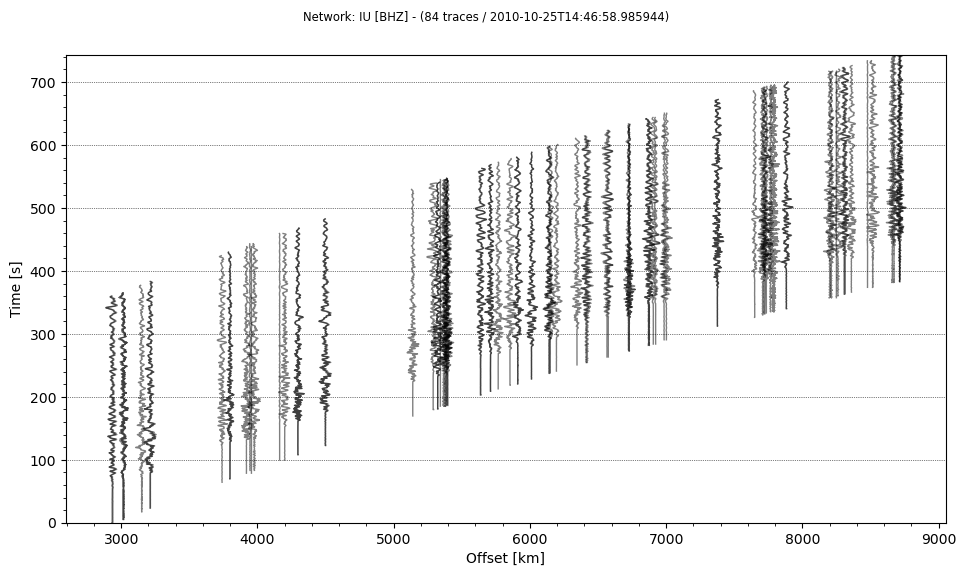

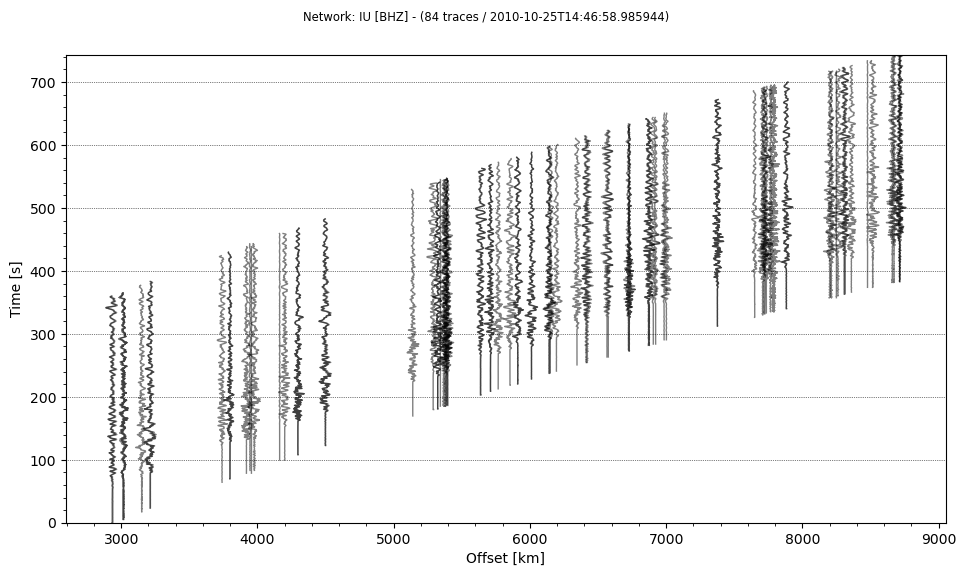

In [38]:
st.plot(type='section')

In [31]:
from rtergpy.waveforms import get_respinv,theorPinfo
from obspy.geodetics.base import gps2dist_azimuth as ll2az
from obspy.clients.fdsn import Client as fdsnClient
fclient=fdsnClient("IRIS")
pwindow=Defaults.waveparams[1]
inventory=get_respinv(Defaults.network,Event.origin[0],Event.origin[1],Defaults.stationrange,Defaults.chan)
for chan in inventory.get_contents().get('channels'):
    if chan == 'IU.DAV.00.BHZ' :
        slat,slon,sz,sldep=inventory.get_coordinates(chan).values()
        sheight=sz-sldep
        sloc=slat,slon,sheight
        Ptime,Ptoa,Prayp,Pinc,distdeg=theorPinfo(eloc,etime,sloc)
        distmeters,az,baz=ll2az(eloc[0],eloc[1],slat,slon)
        neti,stati,loci,chani=chan.split(".")
        print(chan)
        lchan=chan
        stlocal=fclient.get_waveforms(neti,stati,loci,chani,Ptime+pwindow[0],Ptime+pwindow[1], minimumlength=120, longestonly=True)

IU.DAV.00.BHZ


3151676.3928588144 7.0697 125.5791 2010-10-25T14:48:16.194253Z IU.DAV.00.BHZ
               network: IU
               station: DAV
              location: 00
               channel: BHZ
             starttime: 2010-10-25T14:47:16.223583Z
               endtime: 2010-10-25T14:53:16.173583Z
         sampling_rate: 20.0
                 delta: 0.05
                  npts: 7200
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 35, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 17920})
            processing: ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2010, 10, 25, 14, 53, 16, 173583)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2010, 10, 25, 14, 47, 16, 173583))']


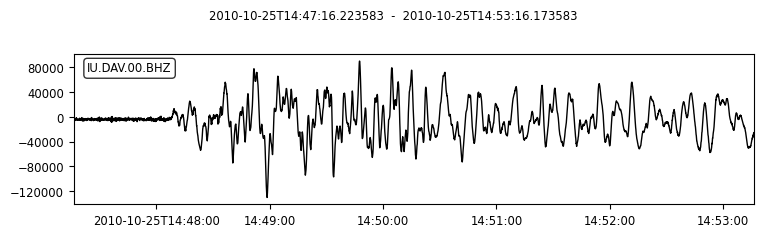

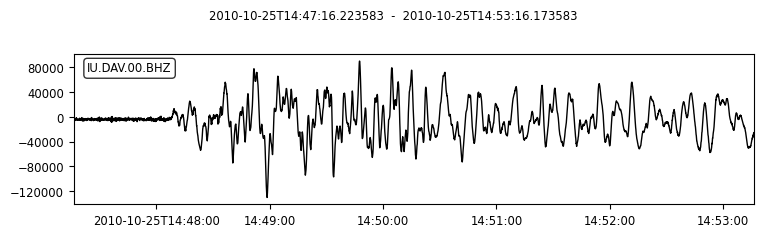

In [35]:
print(distmeters,slat,slon,Ptime,lchan)
print(stlocal[0].stats)
stlocal.plot()

IU.DAV.00.BHZ | 2010-10-25T14:47:16.223583Z - 2010-10-25T14:53:16.123583Z | 10.0 Hz, 3600 samples
AttribDict({'latitude': -8.5259, 'longitude': 179.1966})
79.4522307358 8844704.418707322


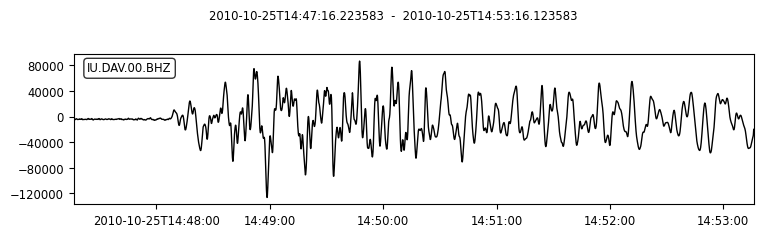

IU.DAV.00.BHZ | 2010-10-25T14:47:16.223583Z - 2010-10-25T14:53:16.123583Z | 10.0 Hz, 3600 samples
2010-10-25T14:54:28.752121Z 2010-10-25T14:53:28.752121Z 2010-10-25T14:59:28.752121Z
IU.DAV.00.BHZ | 2010-10-25T14:53:28.723583Z - 2010-10-25T14:53:28.723583Z | 10.0 Hz, 0 samples


/Users/anewman/opt/anaconda3/envs/rterg/lib/python3.8/site-packages/obspy/core/trace.py:2810: RuntimeWarning: Mean of empty slice.
  data -= data.mean()
/Users/anewman/opt/anaconda3/envs/rterg/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: could not broadcast input array from shape (2,) into shape (0,)

In [36]:
tr=st[57]
print(tr)
print(tr.stats.coordinates)
print(tr.stats.distdeg,tr.stats.distance)
#st[57].plot() # 57 is first dav instance
tr.plot()
trnew=wave2energytinc(tr)
# trace timing information seems to be incorrect

0


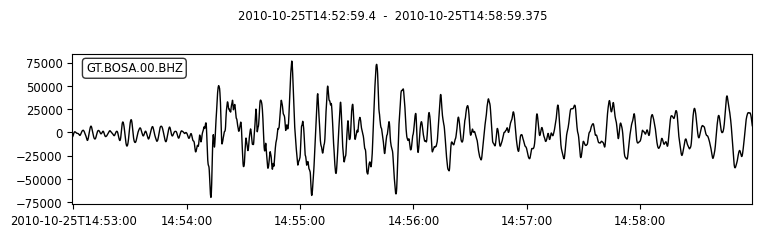

1


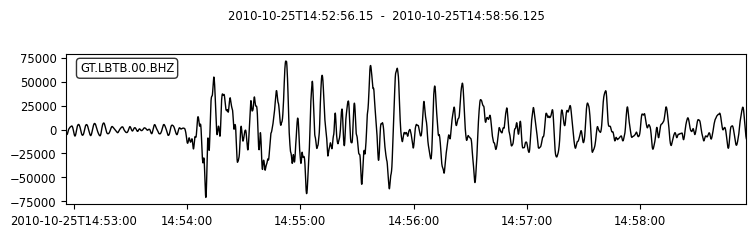

2


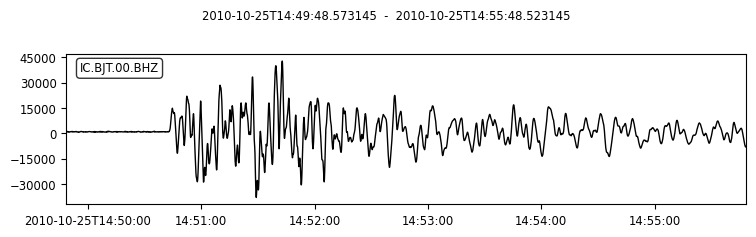

3


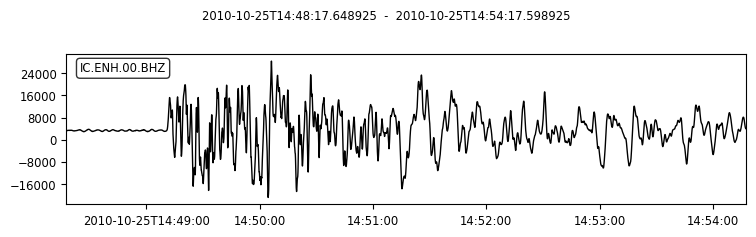

4


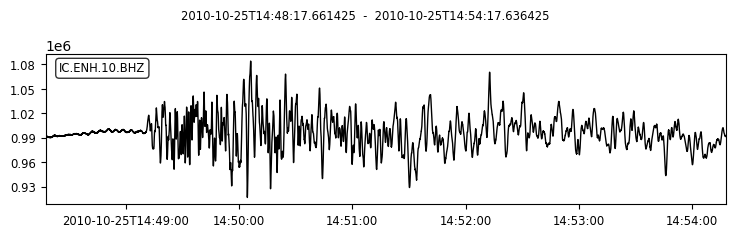

5


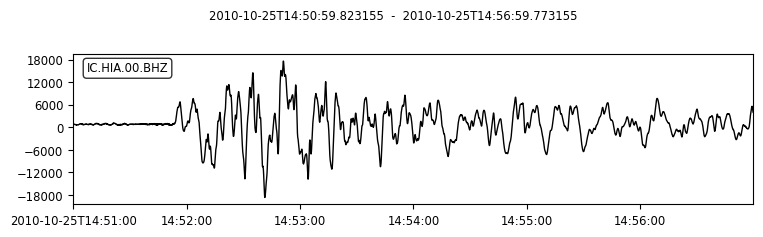

6


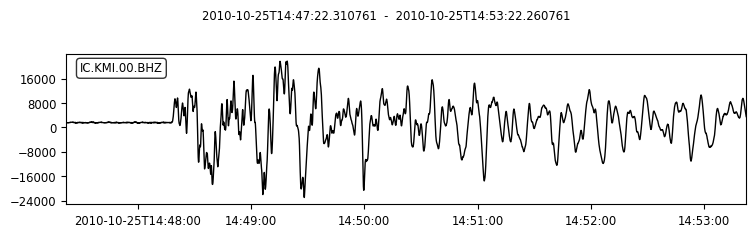

7


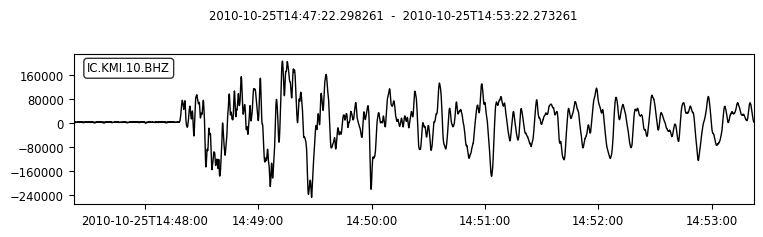

8


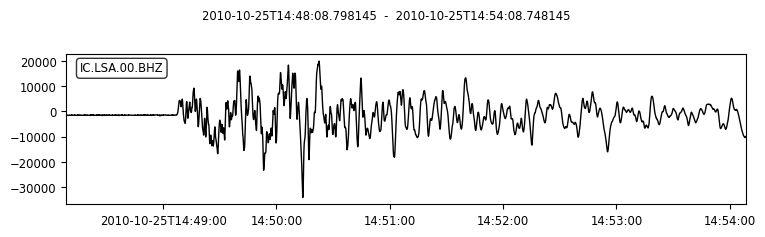

9


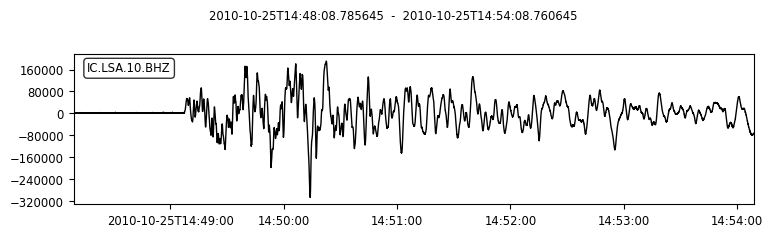

10


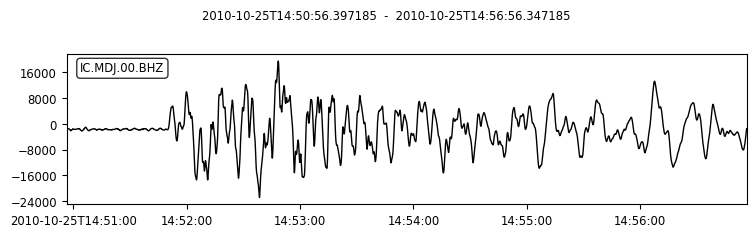

11


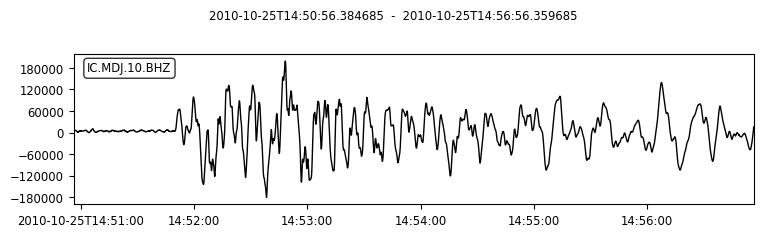

12


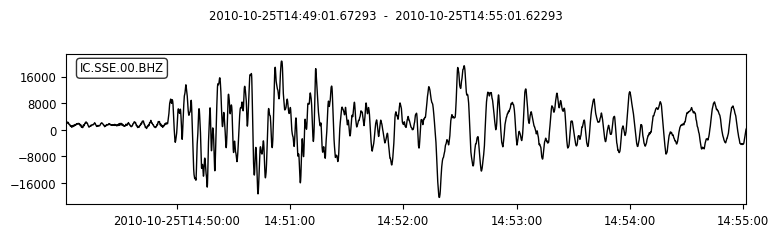

13


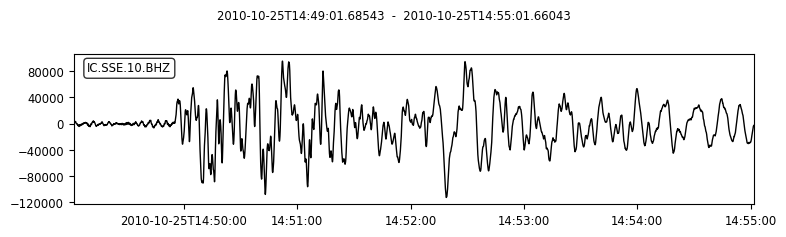

14


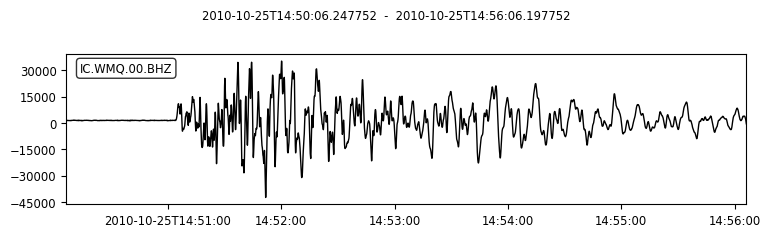

15


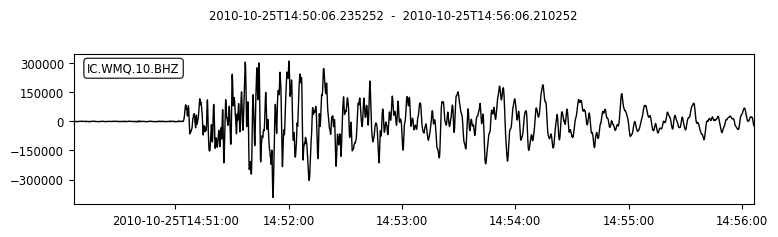

16


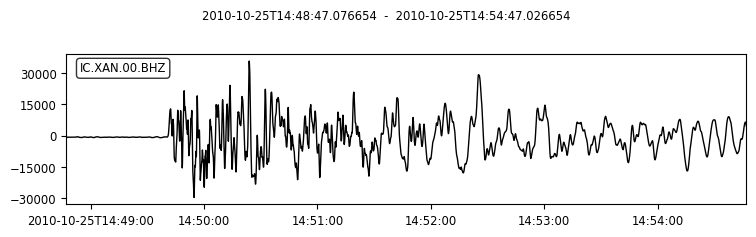

17


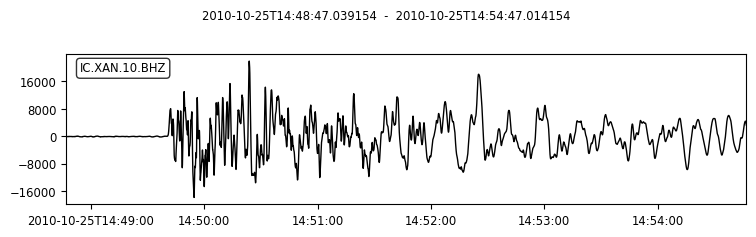

18


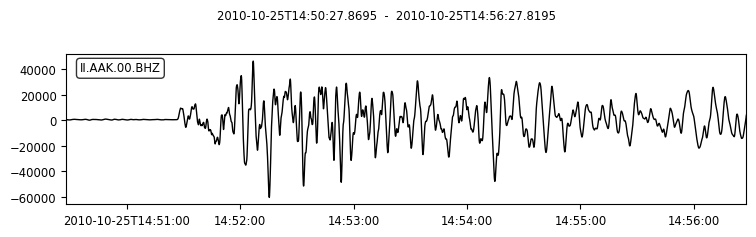

19


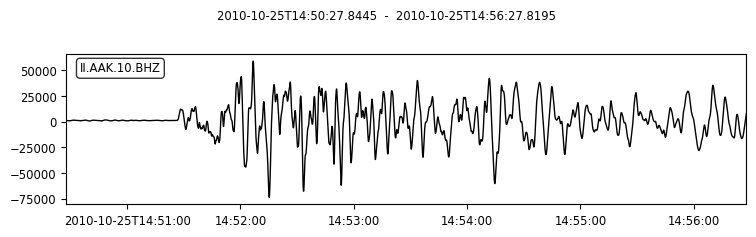

20


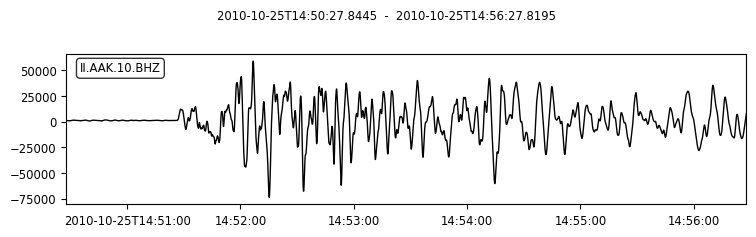

21


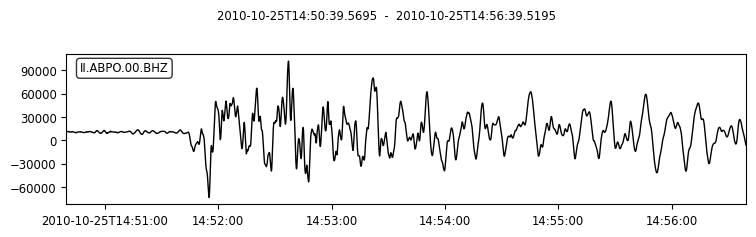

22


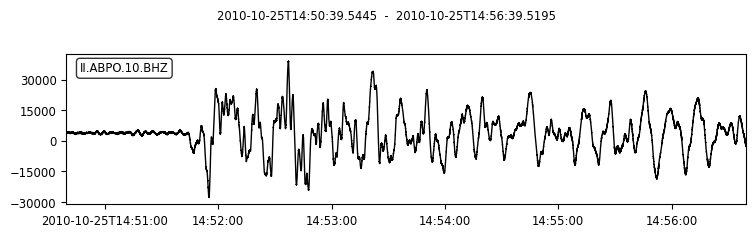

23


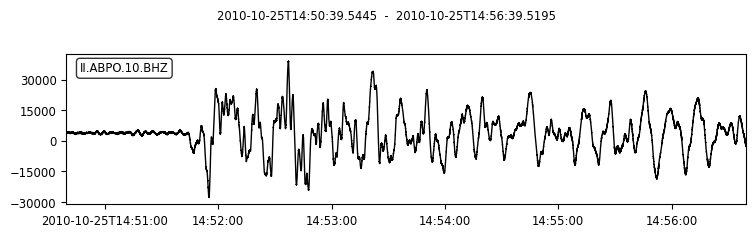

24


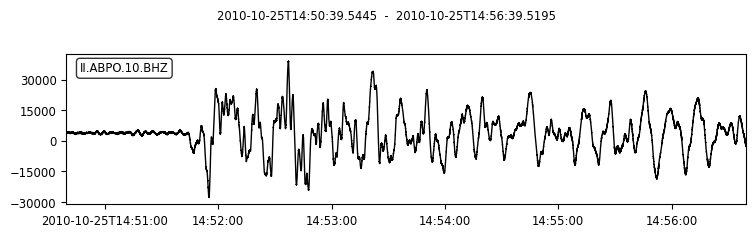

25


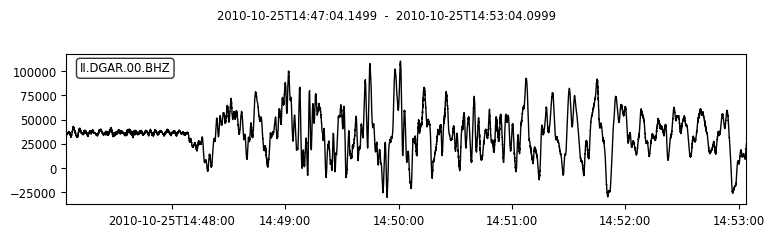

26


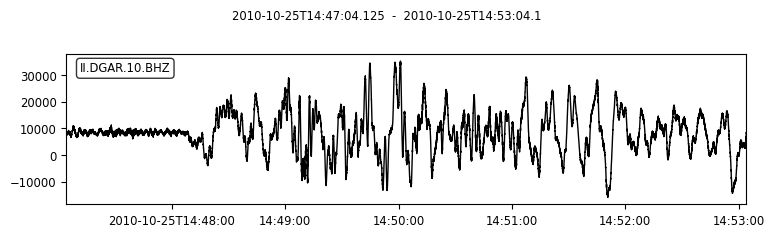

27


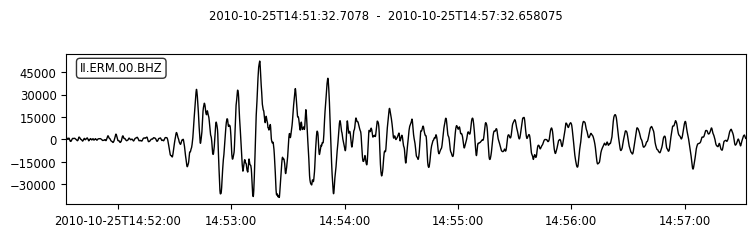

28


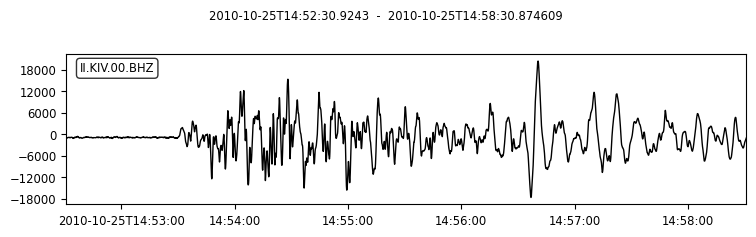

29


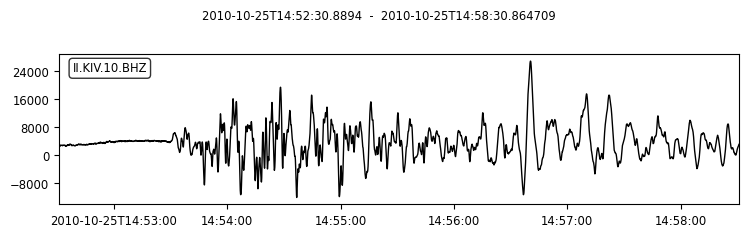

30


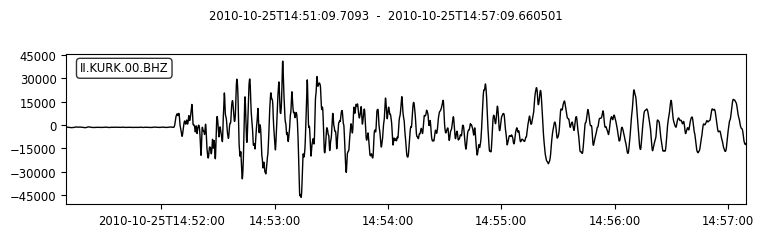

31


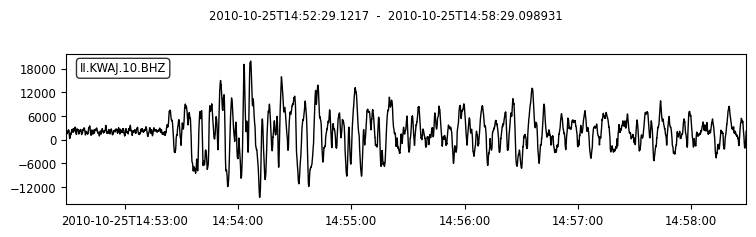

32


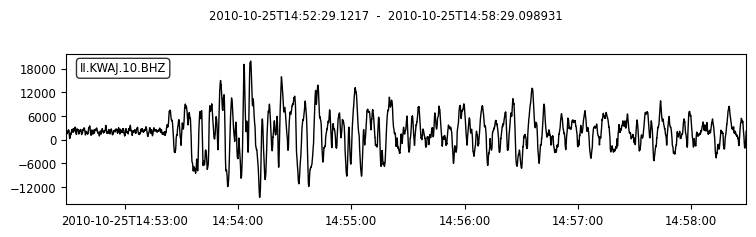

33


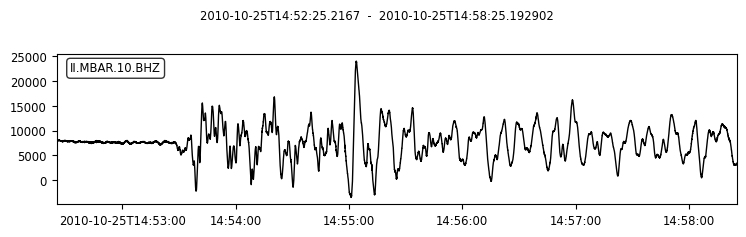

34


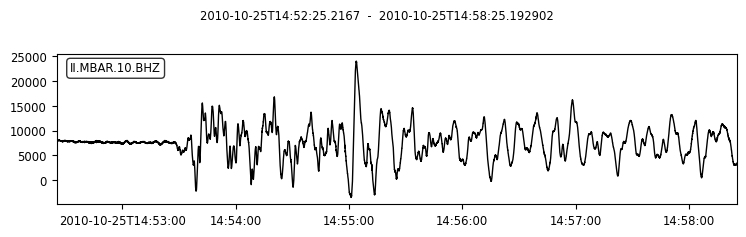

35


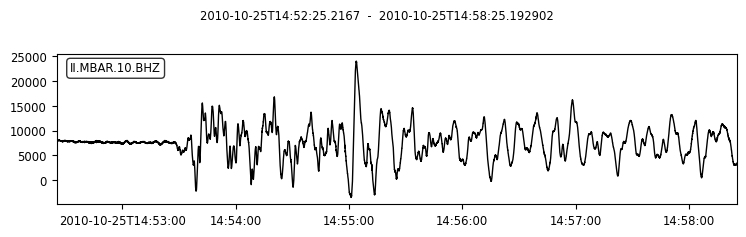

36


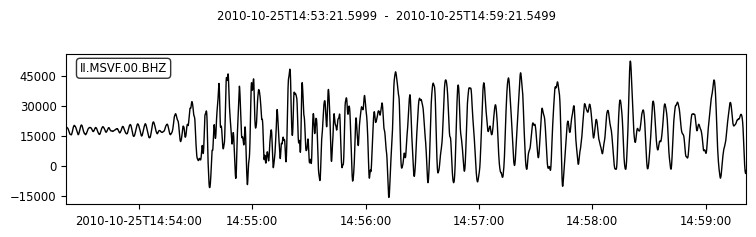

37


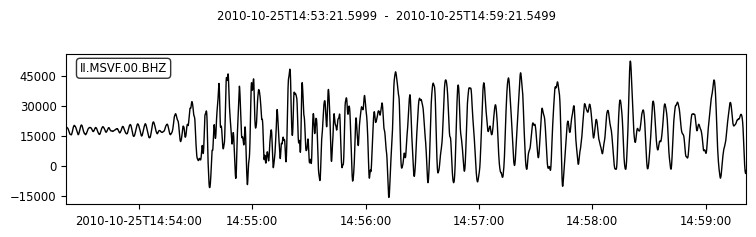

38


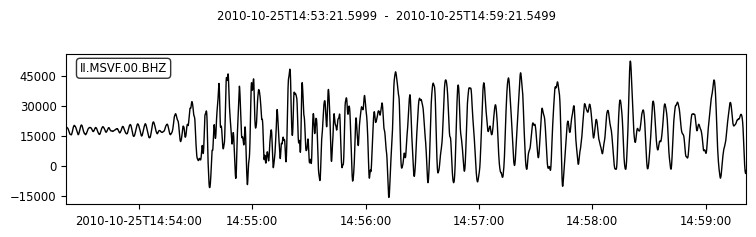

39


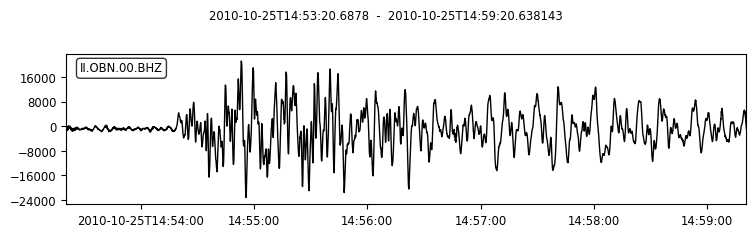

40


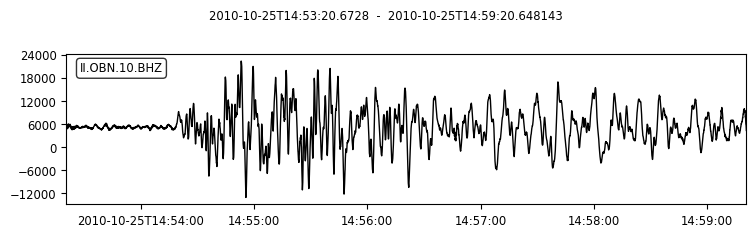

41


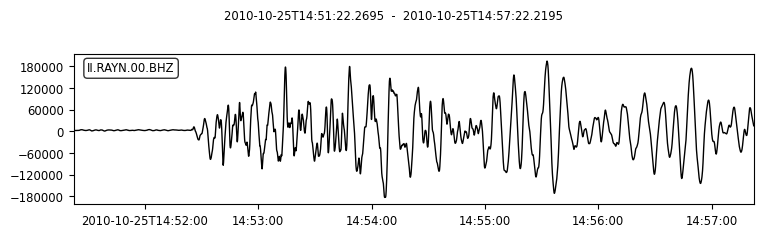

42


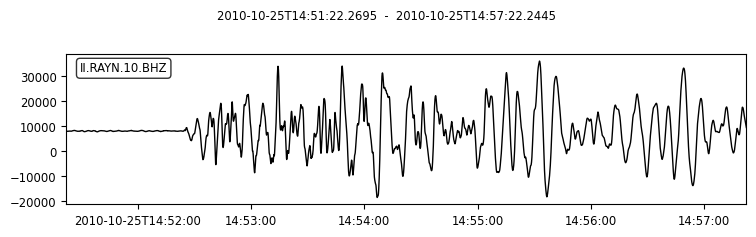

43


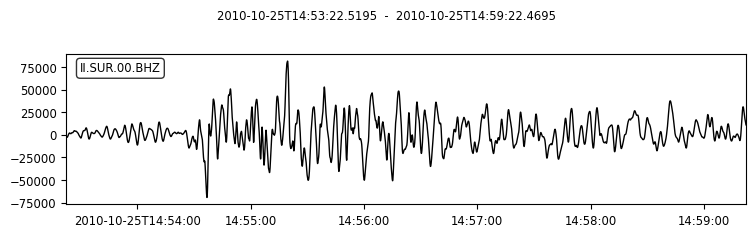

44


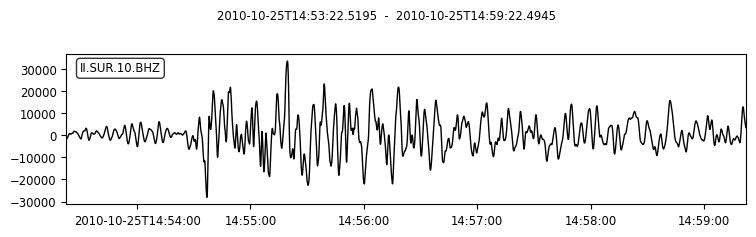

45


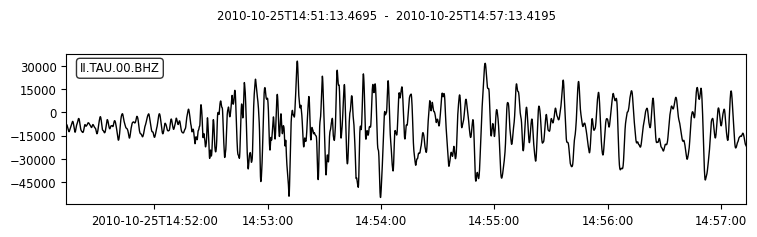

46


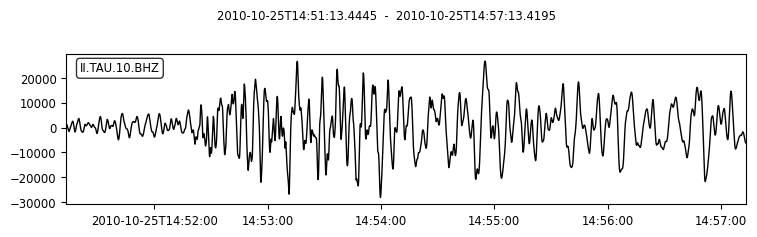

47


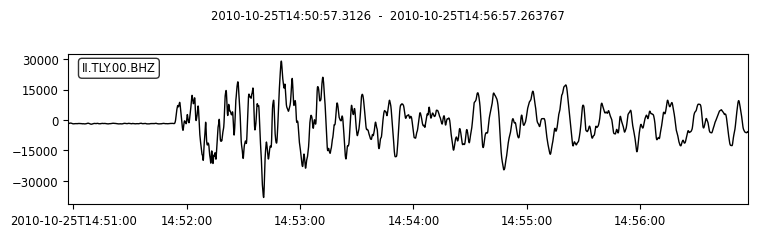

48


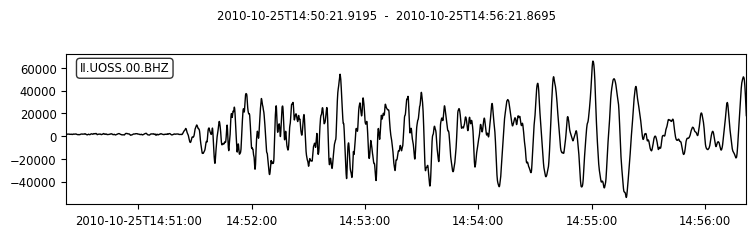

49


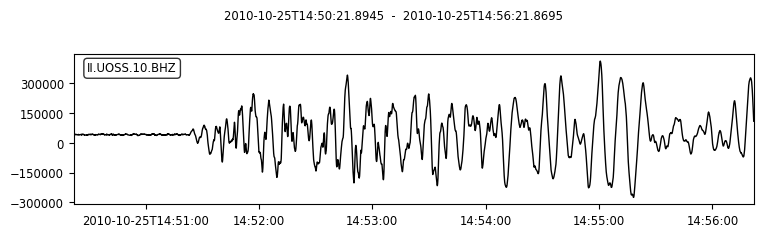

50


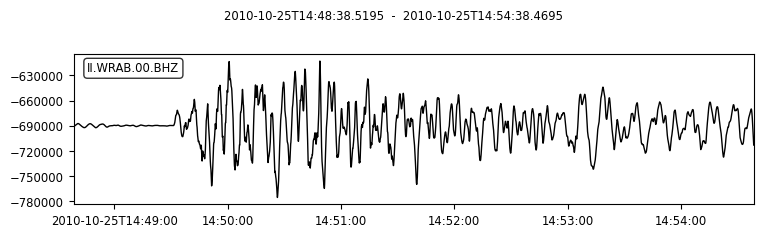

51


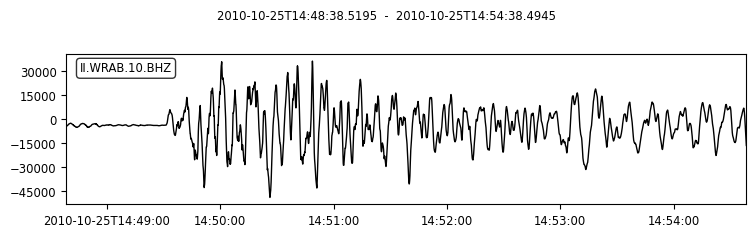

52


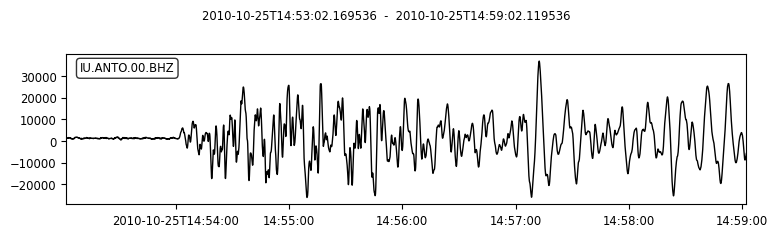

53


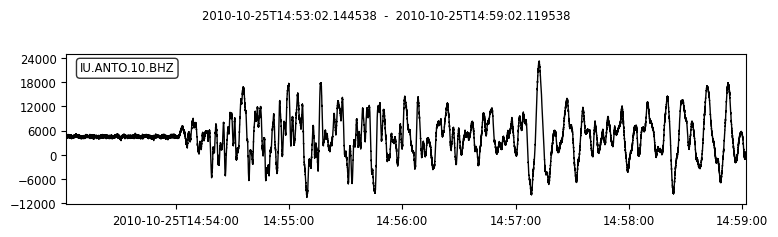

54


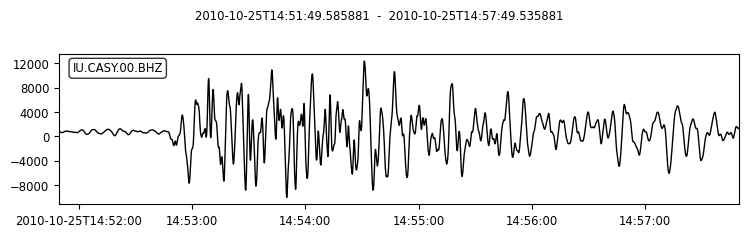

55


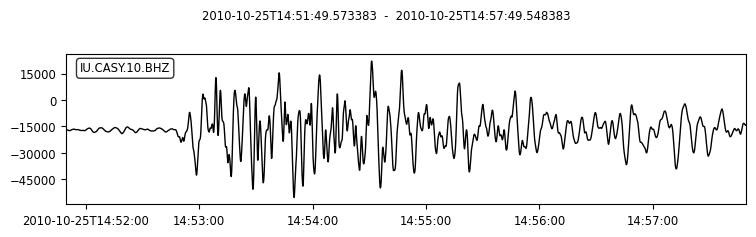

56


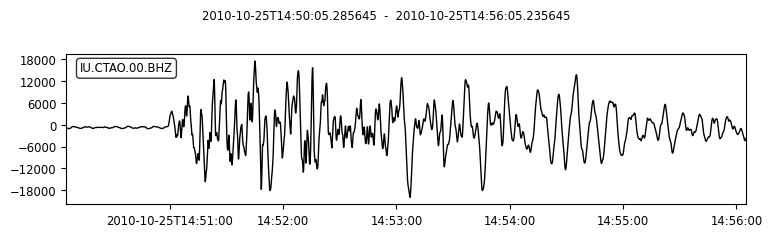

57


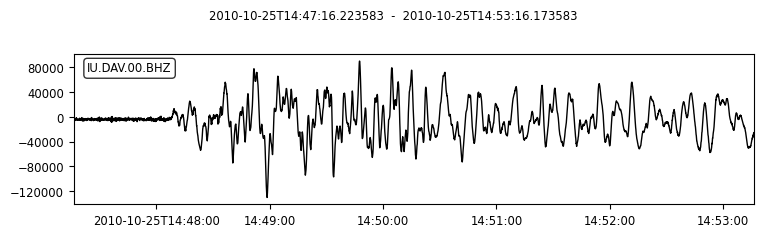

58


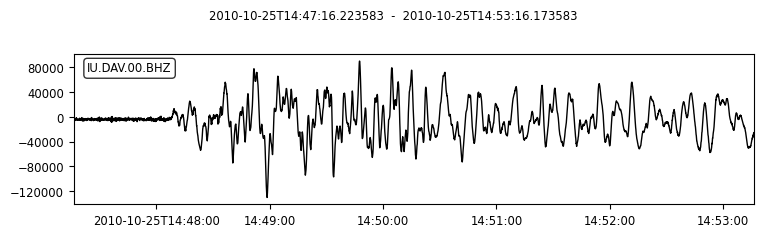

59


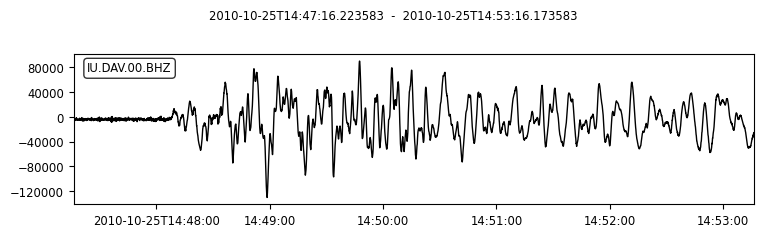

60


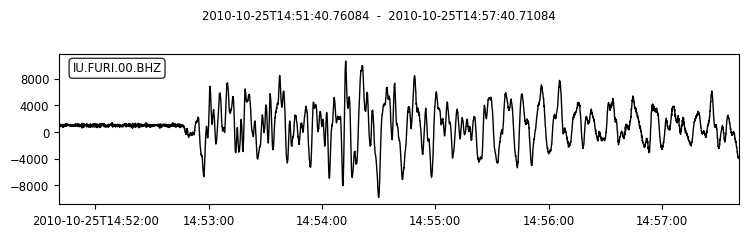

61


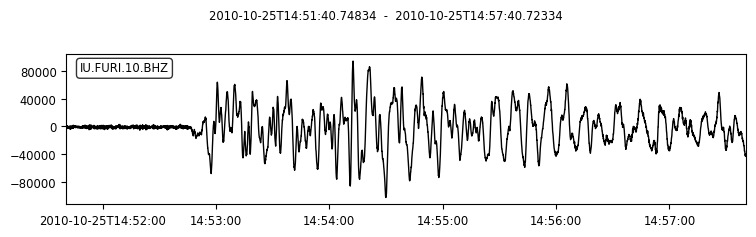

62


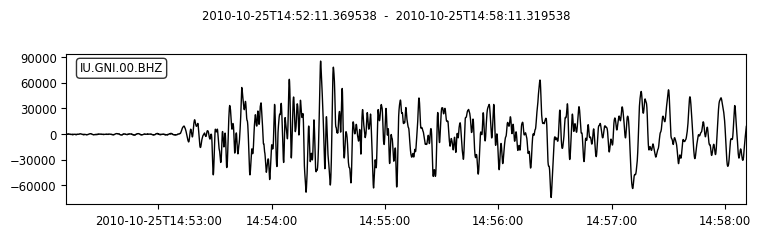

63


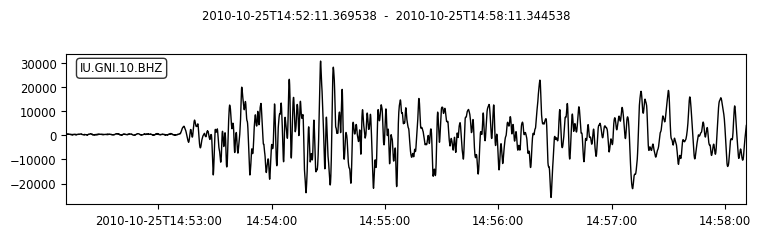

64


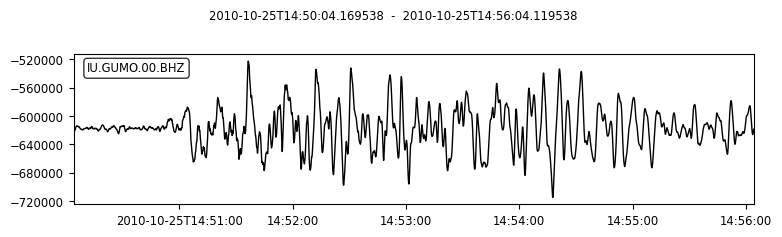

65


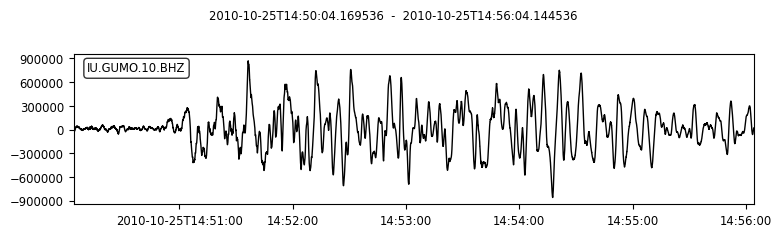

66


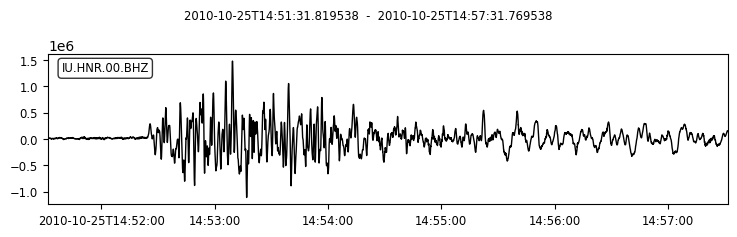

67


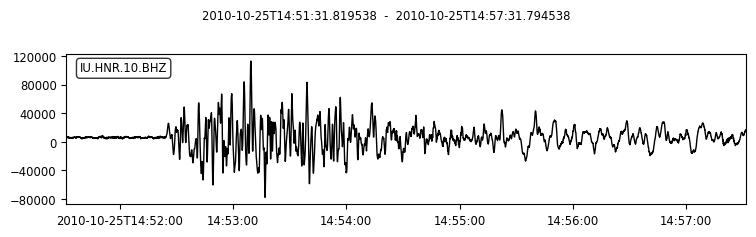

68


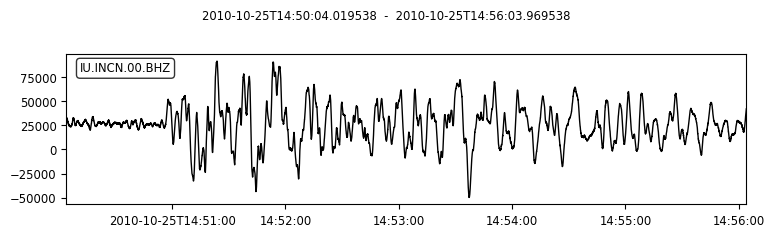

69


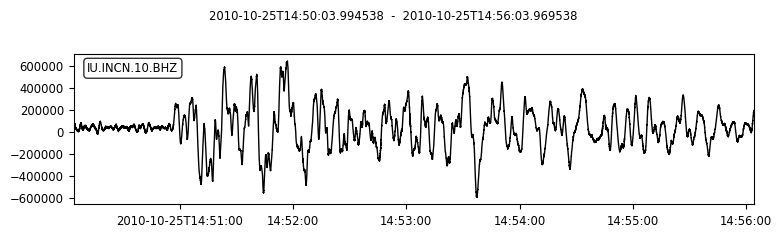

70


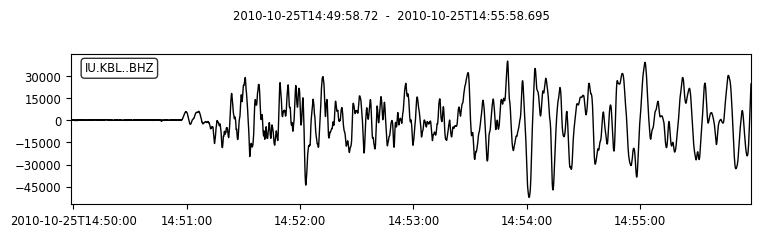

71


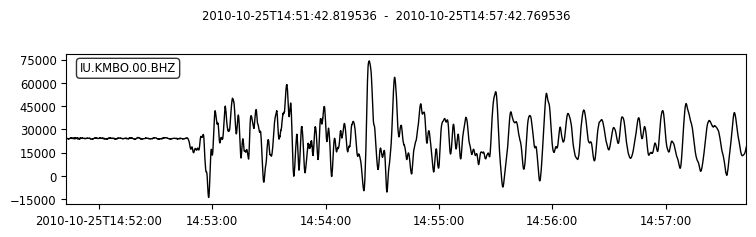

72


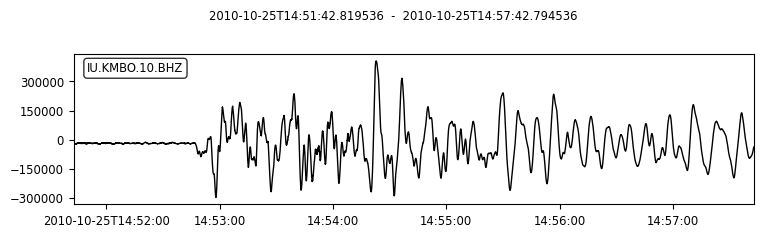

73


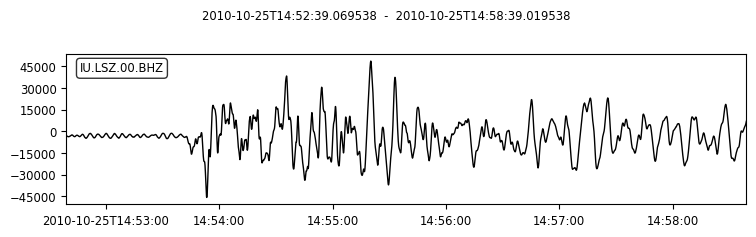

74


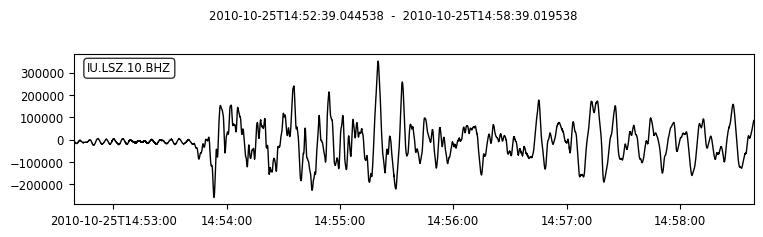

75


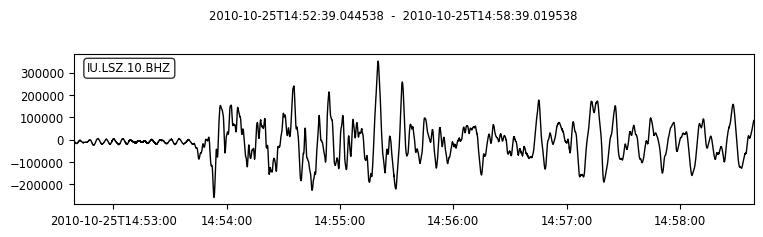

76


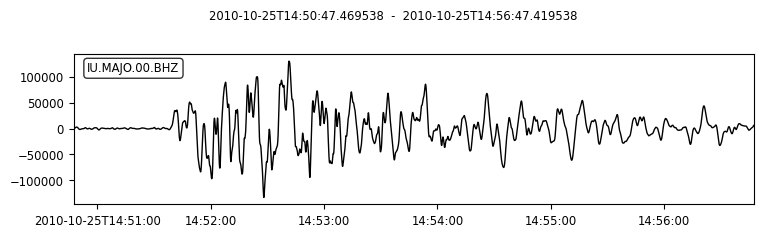

77


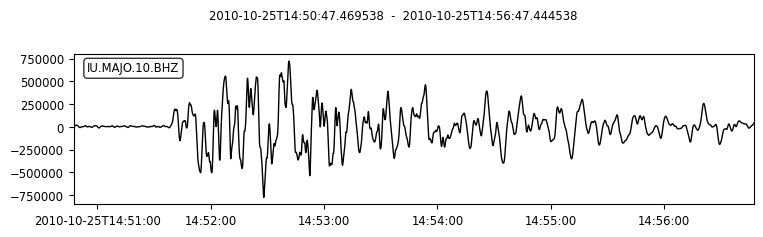

78


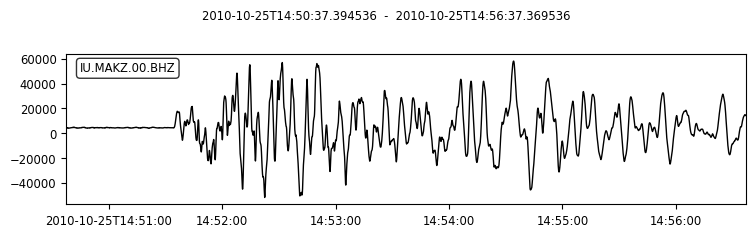

79


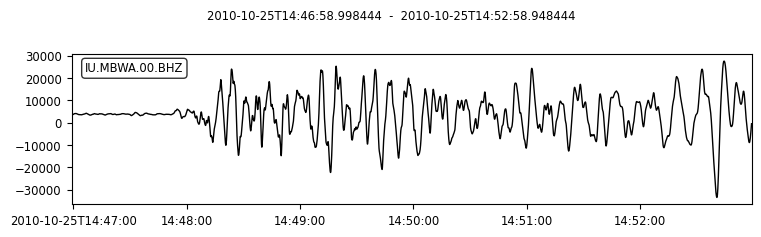

80


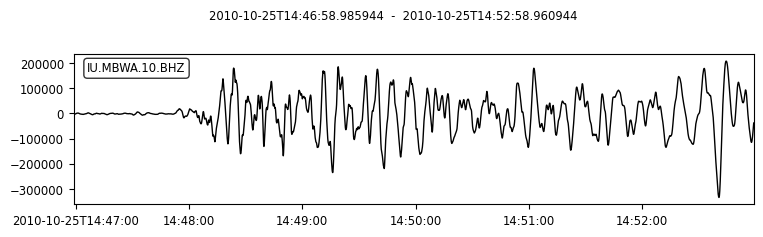

81


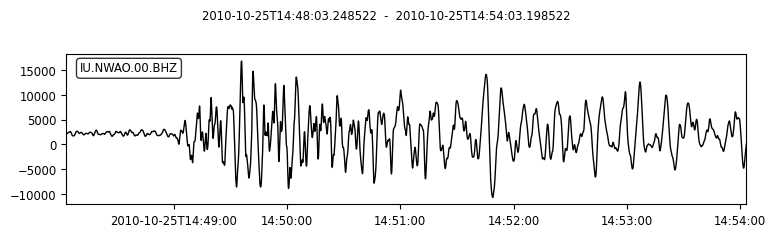

82


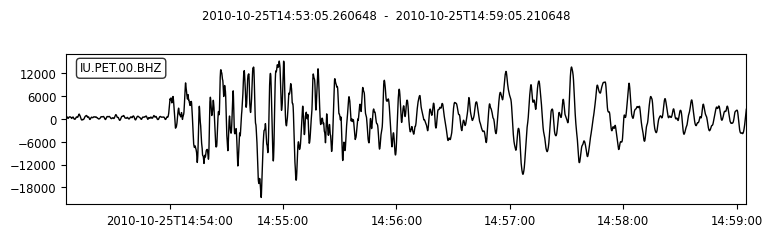

83


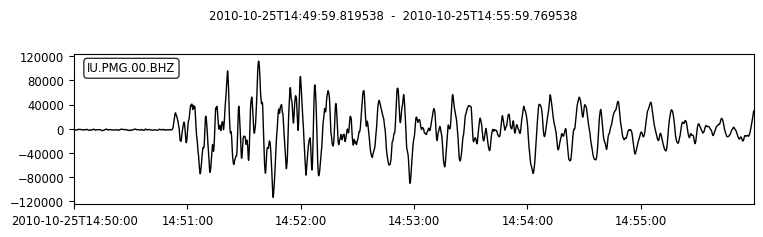

84


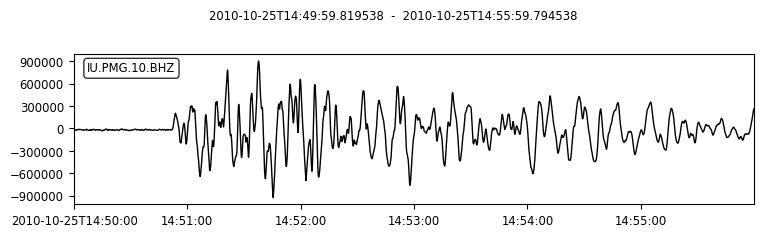

85


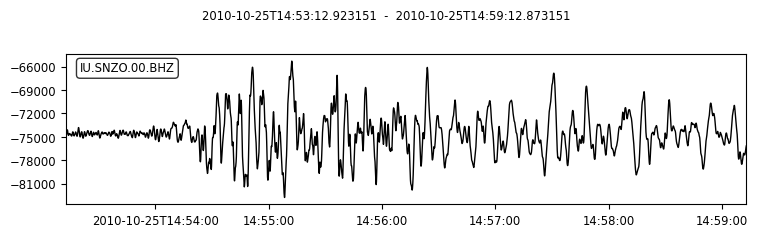

86


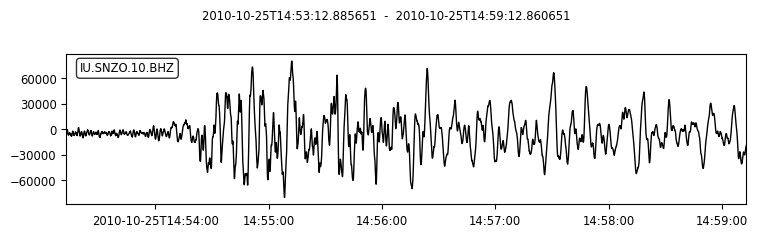

87


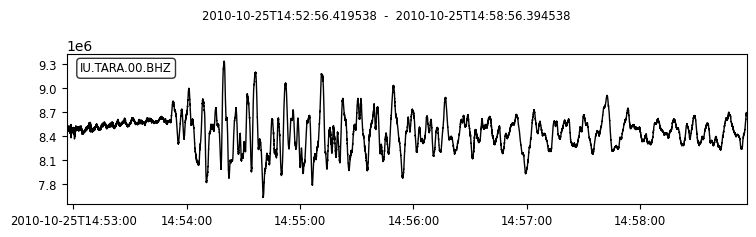

88


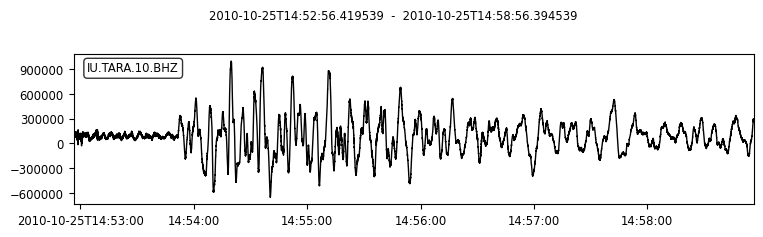

89


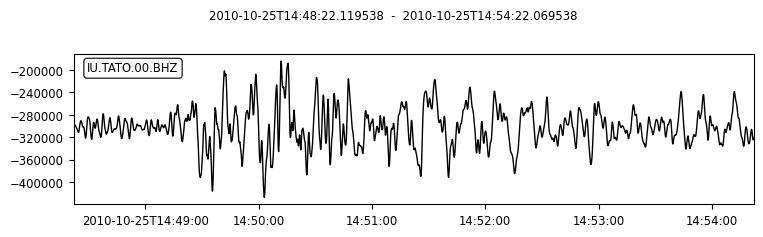

90


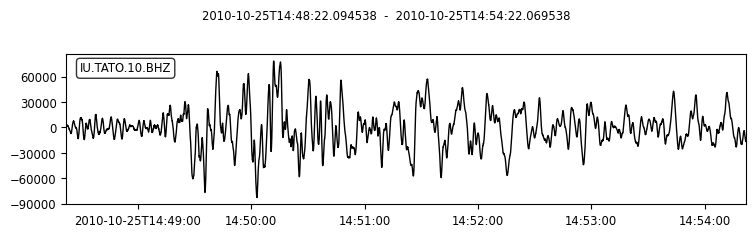

91


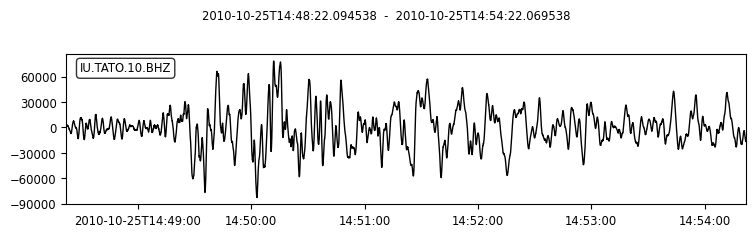

92


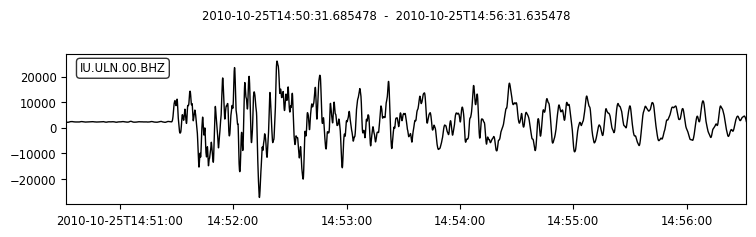

93


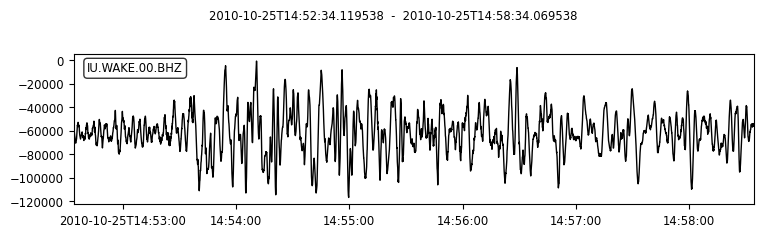

94


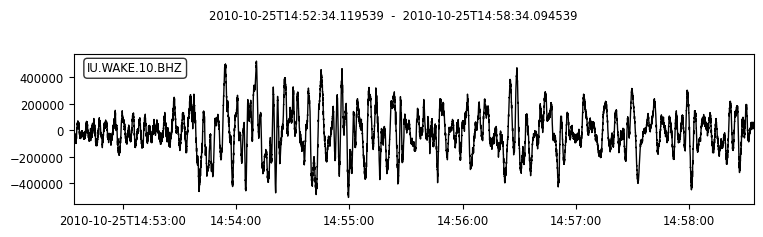

95


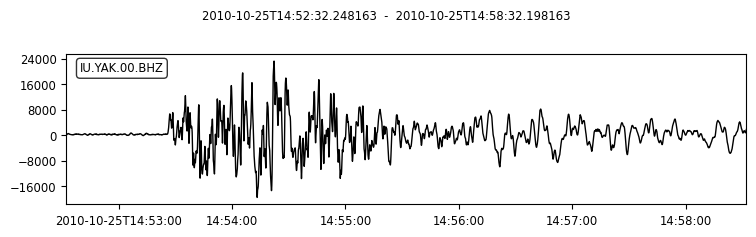

96


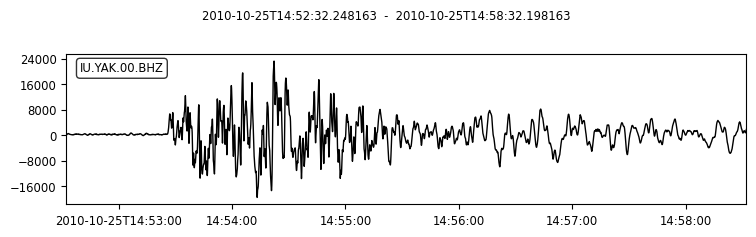

In [13]:
i=0
for tr in st:
    #print(tr.stats.npts, tr)
    print(i)
    tr.plot()
    if tr.count() == 0:
        print("removing :"+str(tr))
        st.remove(tr)
    i = i + 1


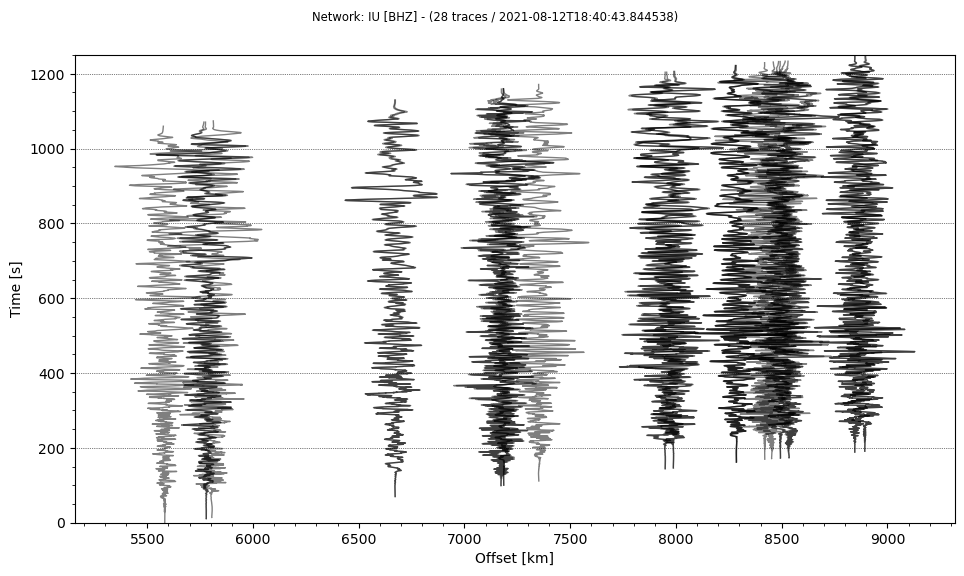

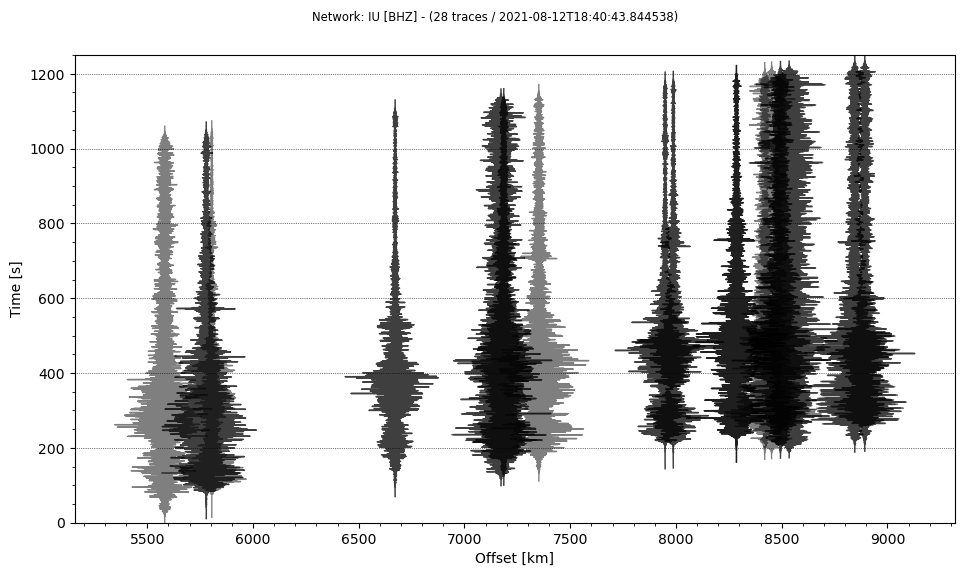

In [ ]:
from rtergpy.waveforms import tacerstats,trstat2pd,e2Me,process_waves, loadwaves
# simple Moveout plt
tr=process_waves(st,freqmin=.001,freqmax=2)
tr.plot(type='section', scale=3);
tr=process_waves(st,freqmin=.5,freqmax=2)
tr.plot(type='section', scale=3);
#tr.plot(type='section', scale=5, dist_degree=True, ev_coord=[eloc[0],eloc[1]], orientation='horizontal', reftime=etime);

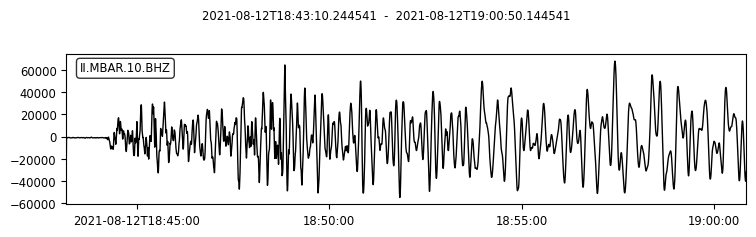

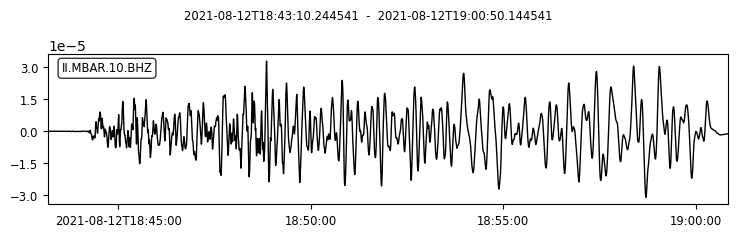

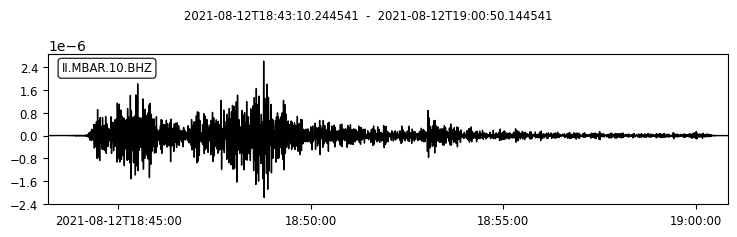

In [ ]:
from rtergpy.waveforms import process_waves
ntr=8
st1=st[ntr]
# raw
st1.plot()
# BB
tr1=process_waves(st1,freqmin=.01,freqmax=2)
tr1.plot()
# HF
tr2=process_waves(st1,freqmin=.5,freqmax=2)
tr2.plot()
plt.show()
#tr.plot(type='section', scale=5, dist_degree=True, ev_coord=[eloc[0],eloc[1]], orientation='horizontal', reftime=etime);

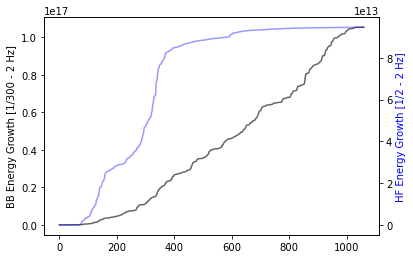

In [ ]:
from rtergpy.plotting import Etincplot

Etincplot(EBB,EHF,EBBmd,EHFmd,trdf,ntr=ntr)

# create other time series products (testing)

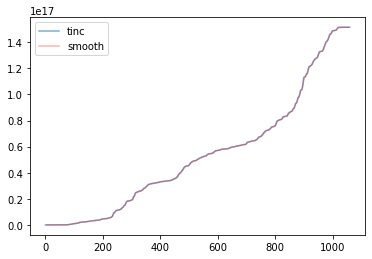

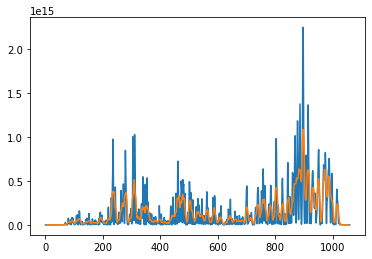

In [ ]:
# create smoothed and 1st derivative products
kern=10
ntr=22
#smoothed=eEtinc_BB["CU.ANWB.00.BHZ"].rolling(kern,win_type='gaussian',center=True, closed='both').mean(std=kern/2)#.round(kern*2)
EBBsmooth=EBB.rolling(kern,win_type='gaussian',center=True, closed='both').mean(std=kern/2)
dEdtBB=EBB.diff()
dEdtBBsmooth=EBBsmooth.diff()
#EtincBBsmooth["CU.ANWB.00.BHZ"].plot()
EBB.iloc[:,ntr].plot(alpha=0.6,label="tinc")
EBBsmooth.iloc[:,ntr].plot(alpha=0.3,color='red',label="smooth")
plt.legend()
plt.show()
dEdtBB.iloc[:,ntr].plot()
dEdtBBsmooth.iloc[:,ntr].plot()
#smoothed.plot()
plt.show()

# Old testing